In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [6]:
iggs = [1, 10]
linestyles = ['--', ':']

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, linestyle in zip(iggs, linestyles):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [8]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [9]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [10]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [11]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, innames())))

vstar = 980

nband = 120

nv = 200

dv = 0.005

tsfc =257

ng =3

nref =1

p_refs = (/ 600 /) 

t_refs = (/ 250 /) 

ng_refs = (/ 3 /) 

data wgt
     &     /0.5 , 0.55 , 0.85/

option_wgt_flux =2

option_wgt_k =1

option_klin =1

data w_diffuse
     &     /1.66 , 1.66 , 1.8/

klin =1e-24

atmosphere_profiles/saw75.pro


In [12]:
fig.display_hrefanchor()

In [13]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [14]:
table_dgdgs.display_hrefanchor()

In [15]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [16]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [17]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

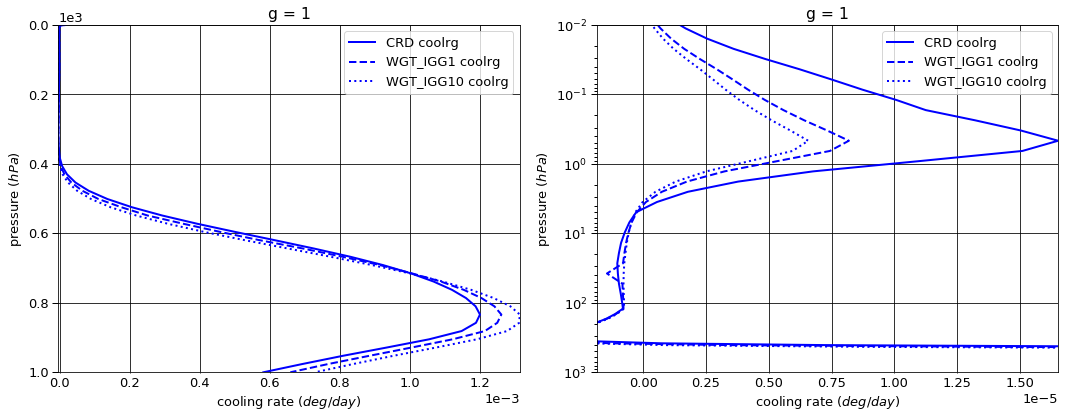

# Figure: cooling rate g-group 2

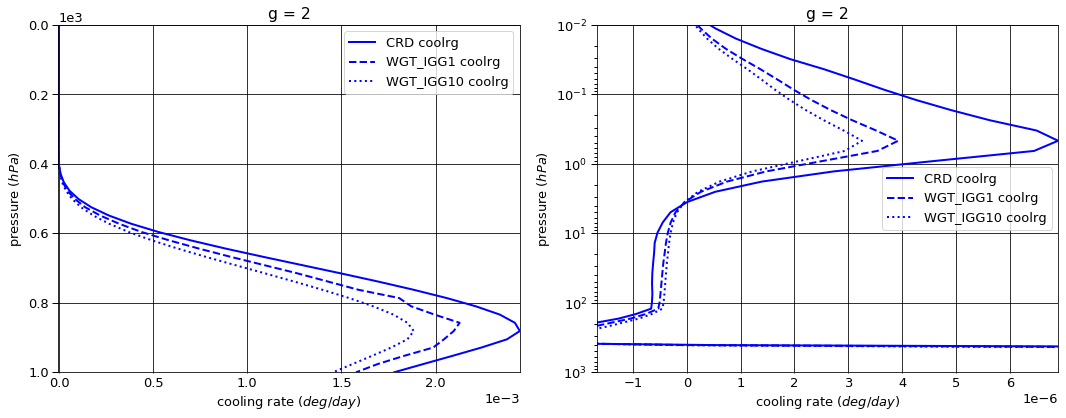

# Figure: cooling rate g-group 3

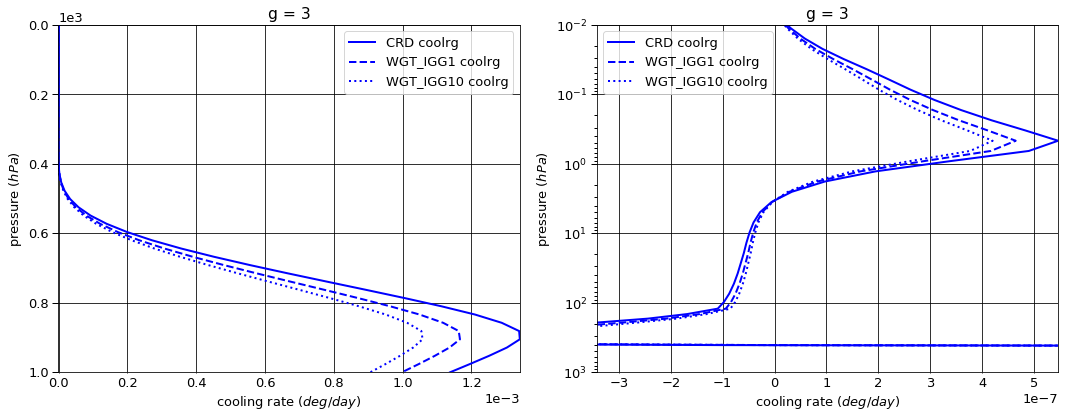

# Figure: cooling rate g-group total

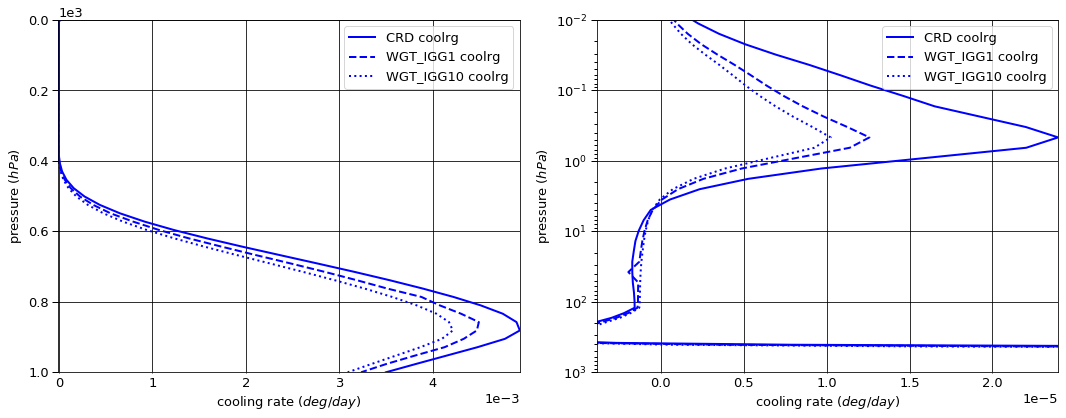

In [18]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [19]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.101560  0.000000  -0.101560
  1013.0   76     -0.106565  0.055443  -0.051122
2 0.0      1      -0.963475  0.000000  -0.963475
  1013.0   76     -0.967837  0.095742  -0.872095
3 0.0      1     -13.975676  0.000000 -13.975676
  1013.0   76    -13.977004  0.048354 -13.928650


WGT_IGG1


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.102093  0.000000  -0.102093
  1013.0   76     -0.106565  0.055973  -0.050593
2 0.0      1      -0.964261  0.000000  -0.964261
  1013.0   76     -0.967837  0.082102  -0.885736
3 0.0      1     -13.975878  0.000000 -13.975878
  1013.0   76    -13.977004  0.041979 -13.935024


WGT_IGG10


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.102605  0.000000  -0.102605
  1013.0   76     -0.106565  0.056253  -0.050313
2 0.0      1      -0.964883  0.000000  -0.964883
  1013.0   76     -0.967837  0.072313  -0.895524
3 0.0      1     -13.975987  0.000000 -13.975987
  1013.0   76    -13.977004  0.038046 -13.938958


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.000533  0.000000 -0.000533
  1013.0   76     0.000000  0.000529  0.000529
2 0.0      1     -0.000786  0.000000 -0.000786
  1013.0   76     0.000000 -0.013641 -0.013641
3 0.0      1     -0.000202  0.000000 -0.000202
  1013.0   76     0.000000 -0.006374 -0.006374


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.001045  0.000000 -0.001045
  1013.0   76     0.000000  0.000809  0.000809
2 0.0      1     -0.001408  0.000000 -0.001408
  1013.0   76     0.000000 -0.023429 -0.023429
3 0.0      1     -0.000311  0.000000 -0.000311
  1013.0   76     0.000000 -0.010308 -0.010308

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -8.860613e-07
  1001.112500 75     5.817275e-04
2 0.000312    1     -6.214939e-07
  1001.112500 75     1.779617e-03
3 0.000312    1     -5.017006e-08
  1001.112500 75     1.137878e-03


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1     -5.640021e-07
  1001.112500 75     6.588237e-04
2 0.000312    1     -3.742491e-07
  1001.112500 75     1.577015e-03
3 0.000312    1     -4.147616e-08
  1001.112500 75     9.978030e-04


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1     -5.252384e-07
  1001.112500 75     7.294462e-04
2 0.000312    1     -3.171233e-07
  1001.112500 75     1.455045e-03
3 0.000312    1     -3.753748e-08
  1001.112500 75     9.059775e-04


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1      3.220592e-07
  1001.112500 75     7.709621e-05
2 0.000312    1      2.472448e-07
  1001.112500 75    -2.026024e-04
3 0.000312    1      8.693902e-09
  1001.112500 75    -1.400746e-04


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      3.608228e-07
  1001.112500 75     1.477187e-04
2 0.000312    1      3.043706e-07
  1001.112500 75    -3.245716e-04
3 0.000312    1      1.263258e-08
  1001.112500 75    -2.319001e-04

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-15.040711,0.000000,-15.040711
1013.0,76,-15.051406,0.199539,-14.851867



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-15.042232,0.000000,-15.042232
1013.0,76,-15.051406,0.180054,-14.871352



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-15.043475,0.000000,-15.043475
1013.0,76,-15.051406,0.166611,-14.884795



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.001521,0.000000,-0.001521
1013.0,76,0.000000,-0.019485,-0.019485



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.002764,0.000000,-0.002764
1013.0,76,0.000000,-0.032928,-0.032928


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000002
1001.112500,75,0.003499



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-9.797273e-07
1001.112500,75,3.233641e-03



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-8.798992e-07
1001.112500,75,3.090469e-03



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,5.779979e-07
1001.112500,75,-2.655808e-04



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,6.778260e-07
1001.112500,75,-4.087530e-04


In [20]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.007583,0.007049
2,0.065917,0.064206
3,0.926500,0.928744


In [21]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.350702e-23
2,1.000478e-24
3,1.361273e-27


In [22]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [23]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.350702e-23,NaN,0.007583,0.007049,0.007583,0.007049,600.0
2,1.000478e-24,0.074071,0.065917,0.064206,0.073500,0.071256,600.0
3,1.361273e-27,0.001361,0.926500,0.928744,1.000000,1.000000,600.0


In [24]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [25]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog       ratio        taulyr
layer g pressure                                                         
1     1 0.000312     1.146250e-23  1.042155e-24   10.998835  5.324552e-10
      2 0.000312     6.938145e-25  2.591980e-26   26.767742  3.349063e-11
      3 0.000312     3.528842e-27  2.067194e-29  170.706890  2.557062e-13
2     1 0.000750     1.208056e-23  1.049931e-24   11.506047  2.251995e-10
      2 0.000750     7.260946e-25  2.618851e-26   27.725696  1.410272e-11
      3 0.000750     3.674050e-27  2.104950e-29  174.543360  1.072308e-13
3     1 0.001052     1.342053e-23  1.064074e-24   12.612403  3.483860e-10
      2 0.001052     7.956893e-25  2.671456e-26   29.784858  2.163014e-11
      3 0.001052     3.988583e-27  2.178056e-29  183.125840  1.632450e-13
4     1 0.001476     1.491137e-23  1.076692e-24   13.849252  5.394786e-10
      2 0.001476     8.725774e-25  2.723790e-26   32.035408  3.321448e-11
      3 0.001476     4.338979e-27  2.256158e-29  192.317130  2.491226e-13
5     1 0.002070     1.654816e-23  1.087929e-24   15.210697  8.346616e-10
      2 0.002070     9.564600e-25  2.775549e-26   34.460215  5.097514e-11
      3 0.002070     4.725362e-27  2.339618e-29  201.971530  3.805146e-13
6     1 0.002904     1.834276e-23  1.098122e-24   16.703756  1.290627e-09
      2 0.002904     1.047917e-24  2.827275e-26   37.064574  7.821442e-11
      3 0.002904     5.152170e-27  2.429925e-29  212.030000  5.819491e-13
7     1 0.004074     2.030784e-23  1.107590e-24   18.335163  1.994338e-09
      2 0.004074     1.147575e-24  2.879671e-26   39.850898  1.199698e-10
      3 0.004074     5.624467e-27  2.529036e-29  222.395700  8.911419e-13
8     1 0.005714     2.245721e-23  1.116637e-24   20.111464  3.079365e-09
      2 0.005714     1.256123e-24  2.933594e-26   42.818569  1.839399e-10
      3 0.005714     6.148113e-27  2.639798e-29  232.900930  1.366314e-12
9     1 0.008015     2.480504e-23  1.125573e-24   22.037707  4.751304e-09
      2 0.008015     1.374275e-24  2.990071e-26   45.961297  2.819224e-10
      3 0.008015     6.729654e-27  2.766586e-29  243.247570  2.097764e-12
10    1 0.011243     2.736704e-23  1.134745e-24   24.117350  7.325467e-09
      2 0.011243     1.502830e-24  3.050420e-26   49.266336  4.319357e-10
      3 0.011243     7.376723e-27  2.916206e-29  252.956160  3.225362e-12
11    1 0.015771     3.015954e-23  1.144588e-24   26.349681  1.128587e-08
      2 0.015771     1.642622e-24  3.116383e-26   52.709251  6.615356e-10
      3 0.015771     8.097923e-27  3.098926e-29  261.313850  4.966484e-12
12    1 0.022122     3.319991e-23  1.155681e-24   28.727576  1.737393e-08
      2 0.022122     1.794542e-24  3.190359e-26   56.248901  1.012788e-09
      3 0.022122     8.903077e-27  3.329989e-29  267.360560  7.659076e-12
13    1 0.031031     3.649154e-23  1.168780e-24   31.221901  2.671490e-08
      2 0.031031     1.958780e-24  3.275485e-26   59.801213  1.549350e-09
      3 0.031031     9.799208e-27  3.631029e-29  269.874120  1.182479e-11
14    1 0.043528     3.963856e-23  1.183871e-24   33.482155  4.061959e-08
      2 0.043528     2.115556e-24  3.369434e-26   62.786675  2.345722e-09
      3 0.043528     1.068044e-26  4.015267e-29  265.995700  1.807851e-11
15    1 0.061057     4.223166e-23  1.201062e-24   35.161929  6.062114e-08
      2 0.061057     2.244364e-24  3.471661e-26   64.648135  3.489433e-09
      3 0.061057     1.142476e-26  4.498413e-29  253.973190  2.712719e-11
16    1 0.085645     4.459605e-23  1.222748e-24   36.471982  8.970496e-08
      2 0.085645     2.361346e-24  3.596285e-26   65.660701  5.148767e-09
      3 0.085645     1.211782e-26  5.136952e-29  235.895130  4.036183e-11
17    1 0.120136     4.707346e-23  1.252202e-24   37.592538  1.327146e-07
      2 0.120136     2.483405e-24  3.761056e-26   66.029467  7.595032e-09
      3 0.120136     1.285877e-26  6.010712e-29  213.930960  6.008245e-11
18    1 0.168516     4.968372e-23  1.292801e-24   38.431069  1.963734e-07
      2 0.168516     2.611255e

# Histogram of wavenumbers in g-group 1

In [26]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
